In [57]:
import numpy as np
import os

import pandas as pd

%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn.feature_selection import RFECV

from sklearn.svm import SVC

import joblib

from libs.container import Container
from libs.nearest import nearest
import dataset

In [2]:
cpu = joblib.cpu_count()

In [3]:
data = dataset.load_scaled()

Reading '/mnt/is0/jbcabral/denoise/dataset/full_scaled.pkl.bz2'


In [4]:
BEST_PARAMS = joblib.load("results/hp_selection.pkl.bz2")
SVC_LINEAR_PARAMS = BEST_PARAMS["svc_linear"].best_params_

del BEST_PARAMS

SVC_LINEAR_PARAMS

{'C': 100, 'kernel': 'linear', 'probability': True}

In [5]:
X_columns = np.array(dataset.FEATURES)
X_columns

array(['Amplitude', 'Autocor_length', 'Beyond1Std', 'Con', 'Eta_e',
       'FluxPercentileRatioMid20', 'FluxPercentileRatioMid35',
       'FluxPercentileRatioMid50', 'FluxPercentileRatioMid65',
       'FluxPercentileRatioMid80', 'Freq1_harmonics_amplitude_0',
       'Freq1_harmonics_amplitude_1', 'Freq1_harmonics_amplitude_2',
       'Freq1_harmonics_amplitude_3', 'Freq1_harmonics_rel_phase_1',
       'Freq1_harmonics_rel_phase_2', 'Freq1_harmonics_rel_phase_3',
       'Freq2_harmonics_amplitude_0', 'Freq2_harmonics_amplitude_1',
       'Freq2_harmonics_amplitude_2', 'Freq2_harmonics_amplitude_3',
       'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2',
       'Freq2_harmonics_rel_phase_3', 'Freq3_harmonics_amplitude_0',
       'Freq3_harmonics_amplitude_1', 'Freq3_harmonics_amplitude_2',
       'Freq3_harmonics_amplitude_3', 'Freq3_harmonics_rel_phase_1',
       'Freq3_harmonics_rel_phase_2', 'Freq3_harmonics_rel_phase_3',
       'Gskew', 'LinearTrend', 'MaxSlope', 'Mean',

In [6]:
sX_columns = np.array(list(joblib.load("results/rfe_features.pkl.bz2")))
sX_columns

array(['Amplitude', 'Autocor_length', 'Eta_e', 'FluxPercentileRatioMid50',
       'FluxPercentileRatioMid65', 'Freq1_harmonics_amplitude_0',
       'Freq1_harmonics_amplitude_1', 'Freq1_harmonics_amplitude_2',
       'LinearTrend', 'Mean', 'MedianBRP', 'PercentAmplitude',
       'PercentDifferenceFluxPercentile', 'Psi_eta', 'Q31', 'Rcs', 'Std',
       'c89_hk_color', 'c89_jh_color', 'c89_jk_color', 'c89_m2', 'c89_m4',
       'n09_c3', 'n09_hk_color', 'n09_jh_color', 'n09_jk_color', 'n09_m2',
       'n09_m4'], dtype='<U31')

In [7]:
uX_columns = np.array([c for c in X_columns if c not in sX_columns])
uX_columns

array(['Beyond1Std', 'Con', 'FluxPercentileRatioMid20',
       'FluxPercentileRatioMid35', 'FluxPercentileRatioMid80',
       'Freq1_harmonics_amplitude_3', 'Freq1_harmonics_rel_phase_1',
       'Freq1_harmonics_rel_phase_2', 'Freq1_harmonics_rel_phase_3',
       'Freq2_harmonics_amplitude_0', 'Freq2_harmonics_amplitude_1',
       'Freq2_harmonics_amplitude_2', 'Freq2_harmonics_amplitude_3',
       'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2',
       'Freq2_harmonics_rel_phase_3', 'Freq3_harmonics_amplitude_0',
       'Freq3_harmonics_amplitude_1', 'Freq3_harmonics_amplitude_2',
       'Freq3_harmonics_amplitude_3', 'Freq3_harmonics_rel_phase_1',
       'Freq3_harmonics_rel_phase_2', 'Freq3_harmonics_rel_phase_3',
       'Gskew', 'MaxSlope', 'MedianAbsDev', 'PairSlopeTrend', 'PeriodLS',
       'Period_fit', 'Psi_CS', 'Skew', 'SmallKurtosis', 'c89_c3', 'ppmb'],
      dtype='<U27')

In [8]:
POSITIONS = {
    "b206": (13, 8),
    "b214": (13, 0),
    "b216": (12, 12),
    'b220': (12, 8),
    "b228": (12, 0),
    'b234': (11, 8),
    'b247': (10, 9),
    'b248': (10, 8),
    'b261': ( 9, 9),
    'b262': ( 9, 8),
    'b263': ( 9, 7),
    'b264': ( 9, 6),
    'b277': ( 8, 7),
    'b278': ( 8, 6),
    "b360": (2, 8),
    'b396': ( 0, 0),
}
for f in data.keys():
    if f not in POSITIONS:
        print(f)

In [9]:
order = sorted(POSITIONS, key=POSITIONS.get, reverse=True)
order

['b206',
 'b214',
 'b216',
 'b220',
 'b228',
 'b234',
 'b247',
 'b248',
 'b261',
 'b262',
 'b263',
 'b264',
 'b277',
 'b278',
 'b360',
 'b396']

In [10]:
import itertools as it
combs = {}
for ta, tb in it.combinations(order, 2):
    k = "{}_{}".format(ta, tb)
    df = pd.concat([data[ta], data[tb]])
    
    cls = {name: idx for idx, name in enumerate(df.tile.unique())}
    df["cls"] = df.tile.apply(cls.get)
    
    combs[k] = df

data = Container(combs)
print(combs.keys())
del combs

cls = {0: 0, 1: 1}

dict_keys(['b206_b214', 'b206_b216', 'b206_b220', 'b206_b228', 'b206_b234', 'b206_b247', 'b206_b248', 'b206_b261', 'b206_b262', 'b206_b263', 'b206_b264', 'b206_b277', 'b206_b278', 'b206_b360', 'b206_b396', 'b214_b216', 'b214_b220', 'b214_b228', 'b214_b234', 'b214_b247', 'b214_b248', 'b214_b261', 'b214_b262', 'b214_b263', 'b214_b264', 'b214_b277', 'b214_b278', 'b214_b360', 'b214_b396', 'b216_b220', 'b216_b228', 'b216_b234', 'b216_b247', 'b216_b248', 'b216_b261', 'b216_b262', 'b216_b263', 'b216_b264', 'b216_b277', 'b216_b278', 'b216_b360', 'b216_b396', 'b220_b228', 'b220_b234', 'b220_b247', 'b220_b248', 'b220_b261', 'b220_b262', 'b220_b263', 'b220_b264', 'b220_b277', 'b220_b278', 'b220_b360', 'b220_b396', 'b228_b234', 'b228_b247', 'b228_b248', 'b228_b261', 'b228_b262', 'b228_b263', 'b228_b264', 'b228_b277', 'b228_b278', 'b228_b360', 'b228_b396', 'b234_b247', 'b234_b248', 'b234_b261', 'b234_b262', 'b234_b263', 'b234_b264', 'b234_b277', 'b234_b278', 'b234_b360', 'b234_b396', 'b247_b248', '

In [11]:
def execute_kfold(clf_name, clasificator, sample,  X_columns, y_column, nfolds):
    print(clf_name)
    
    skf = StratifiedKFold(n_splits=nfolds)
    
    X = sample[X_columns].values
    y = sample[y_column].values
    
    probabilities = None
    predictions = np.array([])
    y_tests = np.array([])
    
    for train, test in skf.split(X, y):
        x_train = X[train]
        y_train = y[train]
        x_test = X[test]
        y_test = y[test]
        
        clf = sklearn.clone(clasificator)
        clf.fit(x_train, y_train)
        
        current_pred = clf.predict(x_test)
        current_prob = clf.predict_proba(x_test)
        
        y_tests = np.hstack([y_tests, y_test])
        predictions = np.hstack([predictions, current_pred])
        probabilities = (
                current_prob if probabilities is None else
                np.vstack([probabilities, current_prob ]))
            
    fpr, tpr, thresholds = metrics.roc_curve(
        y_tests, 1.-probabilities[:,0], pos_label=1)
    prec_rec_curve = metrics.precision_recall_curve(
        y_tests, 1.- probabilities[:,0], pos_label=1)
    
    roc_auc = metrics.auc(fpr, tpr)
    
    result = {
        "clf_name": clf_name,
        "nfolds": nfolds,
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'real_cls': y_tests,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_tests, predictions)}
    return result

In [12]:
%%time

BEST_PARAMS = joblib.load("results/hp_selection.pkl.bz2")
SVC_LINEAR_PARAMS = BEST_PARAMS["svc_linear"].best_params_

del BEST_PARAMS

clf = SVC(**SVC_LINEAR_PARAMS)
clf

CPU times: user 1.61 s, sys: 32.2 ms, total: 1.64 s
Wall time: 1.64 s


SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [13]:
%%time
fname = "results/selected_all_vs_all.pkl.bz2"
if os.path.exists(fname):
    results = joblib.load(fname)
else:
    with joblib.Parallel(n_jobs=-1) as P:
        results = P(
            joblib.delayed(execute_kfold)(clf_name=k, clasificator=clf, sample=v, X_columns=sX_columns, y_column="cls", nfolds=10)
            for k, v in data.items())
    joblib.dump(results, fname, compress=3)

selected_results = [Container(e) for e in results]

CPU times: user 1.79 s, sys: 13.2 ms, total: 1.81 s
Wall time: 1.82 s


In [16]:
%%time
fname = "results/unselected_all_vs_all.pkl.bz2"
if os.path.exists(fname):
    results = joblib.load(fname)
else:
    with joblib.Parallel(n_jobs=-1) as P:
        results = P(
            joblib.delayed(execute_kfold)(clf_name=k, clasificator=clf, sample=v, X_columns=uX_columns, y_column="cls", nfolds=10)
            for k, v in data.items())
    joblib.dump(results, fname, compress=3)

unselected_results = [Container(e) for e in results]

CPU times: user 2.43 s, sys: 16.1 ms, total: 2.45 s
Wall time: 2.47 s


In [17]:
%%time
fname = "results/afeats_all_vs_all.pkl.bz2"
if os.path.exists(fname):
    results = joblib.load(fname)
else:
    with joblib.Parallel(n_jobs=-1) as P:
        results = P(
            joblib.delayed(execute_kfold)(clf_name=k, clasificator=clf, sample=v, X_columns=X_columns, y_column="cls", nfolds=10)
            for k, v in data.items())
    joblib.dump(results, fname, compress=3)

afeats_results = [Container(e) for e in results]

CPU times: user 1.86 s, sys: 15 ms, total: 1.88 s
Wall time: 1.88 s


In [62]:
selected_results[0]

<Container({'clf_name': <class 'str'>, 'confusion_matrix': <class 'numpy.ndarray'>, 'fpr': <class 'numpy.ndarray'>, 'nfolds': <class 'int'>, 'prec_rec_curve': <class 'tuple'>, 'predictions': <class 'numpy.ndarray'>, 'probabilities': <class 'numpy.ndarray'>, 'real_cls': <class 'numpy.ndarray'>, 'roc_auc': <class 'numpy.float64'>, 'thresh': <class 'numpy.ndarray'>, 'tpr': <class 'numpy.ndarray'>})>

In [63]:
def store_table(results, filename):
    rows = []
    for r in sorted(results, key=lambda e: e["clf_name"]):  
        r = Container(r)
        ta, tb = r.clf_name.split("_")
        row = {
            "Tile A": ta, 
            "Tile B": tb,
            "Prec.": metrics.precision_score(r.real_cls, r.predictions),
            "Recall": metrics.recall_score(r.real_cls, r.predictions),
            "AUC": r.roc_auc}
        rows.append(row)
    df = pd.DataFrame(rows)[["Tile A", "Tile B", "Prec.", "Recall", "AUC"]]
    joblib.dump(df, f"results/{filename}", compress=3)
    return df

selected_table = store_table(selected_results, "selected_all_vs_all_table.pkl.bz2")
unselected_table =  store_table(unselected_results, "unselected_all_vs_all_table.pkl.bz2")
afeats_table =  store_table(afeats_results, "afeats_all_vs_all_table.pkl.bz2")

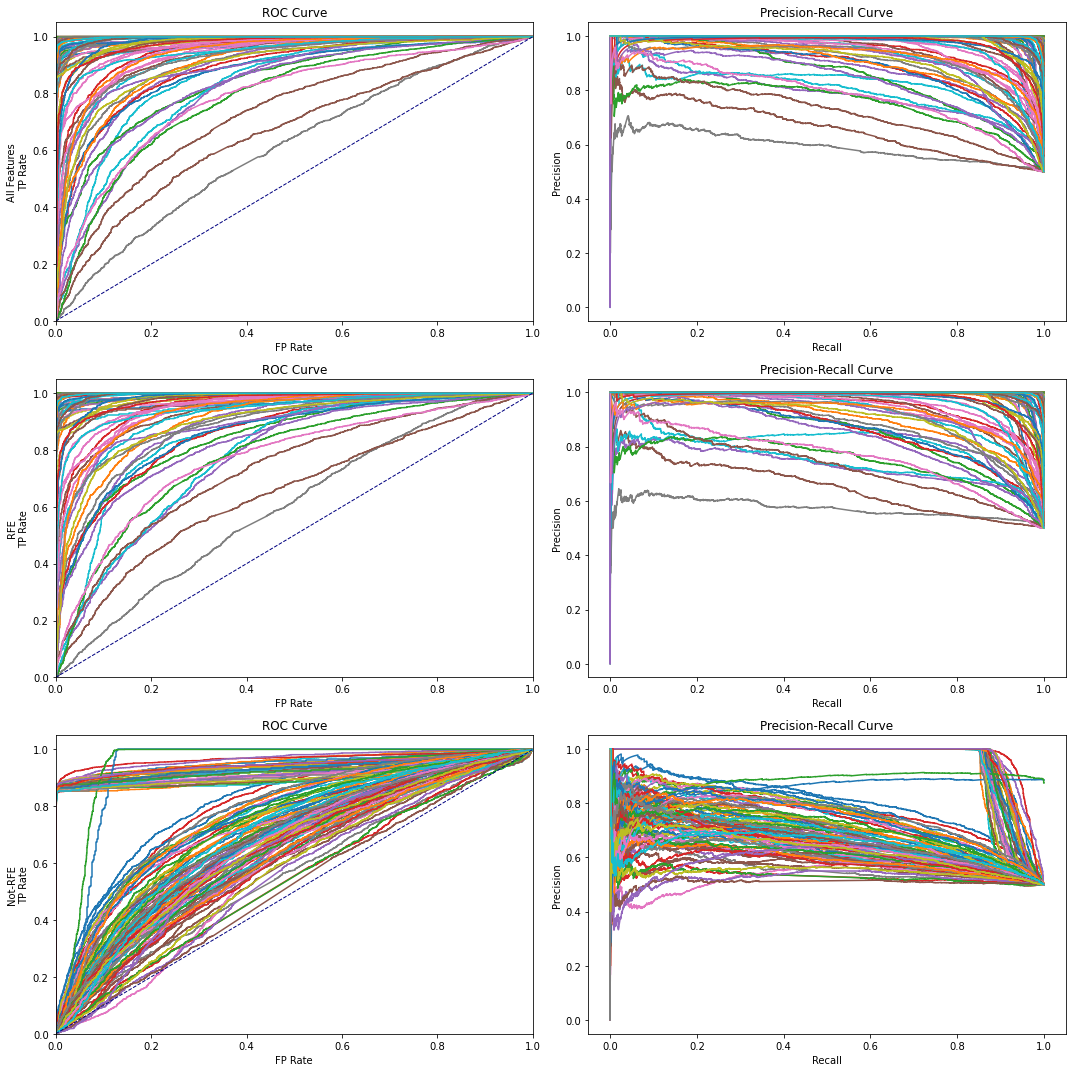

In [42]:
def roc(results, ax=None, labels=True):
    if ax == None:
        ax = plt.gca()

    for res in results:
        cname = "{}".format(res.clf_name)
        label = res.clf_name if labels else "_no_legend_"
        ax.plot(res["fpr"], res["tpr"],  label=label)

    ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FP Rate')
    ax.set_ylabel('TP Rate')
    ax.set_title('ROC Curve')
    
    return ax


def prc(results, ax=None, labels=True):
    if ax == None:
        ax = plt.gca()
        
    for r in results:
        label = r.clf_name if labels else "_no_legend_"
        ax.plot(r.prec_rec_curve[1], r.prec_rec_curve[0], label=label)
        
    ax.set_title("Precision-Recall Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

ax = axes[0]
roc(afeats_results, ax=ax[0])
prc(afeats_results, ax=ax[1], labels=False)
ax[0].set_ylabel("All Features\n" + ax[0].get_ylabel())

ax = axes[1]
roc(selected_results, ax=ax[0], labels=False)
prc(selected_results, ax=ax[1], labels=False)
ax[0].set_ylabel("RFE\n" + ax[0].get_ylabel())

ax = axes[2]
roc(unselected_results, ax=ax[0], labels=False)
prc(unselected_results, ax=ax[1], labels=False)
ax[0].set_ylabel("Not-RFE\n" + ax[0].get_ylabel())

#lgd = fig.legend()
fig.tight_layout();

In [50]:
unselected_table

,Tile A,Tile B,Prec.,Recall,AUC
0,b206,b214,0.998502,1.0000,0.999994
1,b206,b216,0.985561,0.9215,0.987597
2,b206,b220,0.991480,0.9310,0.989641
3,b206,b228,0.998502,1.0000,0.999997
4,b206,b234,0.997463,0.9830,0.999413
...,...,...,...,...,...
115,b277,b360,0.989940,0.9840,0.999385
116,b277,b396,0.723920,0.7460,0.787567
117,b278,b360,0.995498,0.9950,0.999851
118,b278,b396,0.830715,0.8195,0.901490


In [52]:
selected_table

,Tile A,Tile B,Prec.,Recall,AUC
0,b206,b214,0.998502,1.0000,0.999994
1,b206,b216,0.985561,0.9215,0.987597
2,b206,b220,0.991480,0.9310,0.989641
3,b206,b228,0.998502,1.0000,0.999997
4,b206,b234,0.997463,0.9830,0.999413
...,...,...,...,...,...
115,b277,b360,0.989940,0.9840,0.999385
116,b277,b396,0.723920,0.7460,0.787567
117,b278,b360,0.995498,0.9950,0.999851
118,b278,b396,0.830715,0.8195,0.901490
